In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [4]:
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import vice
import apogee_analysis as aah
from astropy.table import Table
import plotting_utils as plotting
import astropy as ap
import astropy.units as u

In [3]:
file_name = "allStar-dr17-synspec_rev1.fits.1"

In [9]:
1<<0

1

In [16]:
ff = fits.open(file_name, mmap=True)
da = ff[1].data
ff.close()

'ancillary young embedded cluster member', 'ancillary emission line star', 'MIR-detected candidate cluster member (ancillary)', 

APOGEE2_Target3: 'Selected as part of the EB program', 'Selected as part of the young cluster study (IN-SYNC)', 'Ancillary W3/4/5 star forming complex'

              

Finally, I restrict to the given Log(g)-Teff domain:
log(g) ≥ 3.5
log(g) ≤ 0.004 ∗ (𝑇eff ) − 15.7
log(g) ≤ 0.00070588 ∗ (𝑇eff ) + 0.358836
log(g) ≤ −0.0015 ∗ (𝑇eff ) + 12.05
log(g) ≥ 0.0012 ∗ (𝑇eff ) − 2.8

In [31]:
apogee_target2 = 1<<17 #APOGEE_MIRCLUSTER_STAR
apogee_target2 ^= 1<<15 #APOGEE_EMISSION_STAR  emission line stars
apogee_target2 ^= 1<<13 #APOGEE_EMBEDDEDCLUSTER_STAR embedded cluster

In [34]:
apogee2_target3 = 1<<5 # young cluster (IN-SYNC)
apogee2_target3 ^= 1<<18 #APOGEE2_W345
apogee2_target3 ^= 1<<1 # EB planet

In [140]:
mask = (da["APOGEE2_TARGET3"] & apogee2_target3) == 0
print(sum(mask))
mask &= (da["APOGEE_TARGET2"] & apogee_target2) == 0
print(sum(mask))

721431
717682


In [35]:
logg = da["LOGG"]
teff = da["TEFF"]

mask &= logg >= 3.5
mask &= logg <= 0.004*teff - 15.7
mask &= logg <= 0.00070588*teff + 0.358836
mask &= logg <= -0.0015 * teff + 12.05
mask &= logg >= 0.0012*teff - 2.8

In [36]:
sum(mask)

16396

In [40]:
# cuts in W+19
filtered = da[mask]
# del da

Text(0, 0.5, 'log g')

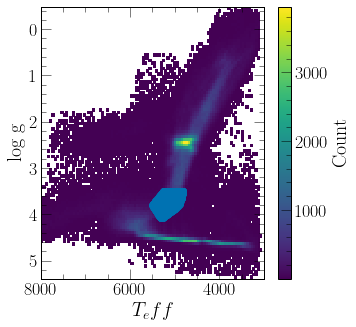

In [139]:
plotting.density_scatter(da["TEFF"], da["LOGG"], density=False, xlim=(3000, 8000))
plt.scatter(filtered["TEFF"], filtered["LOGG"])

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel("$T_eff$")
plt.ylabel("log g")

In [53]:
df = pd.DataFrame(filtered.tolist(), columns = [c.name for c in filtered.columns])

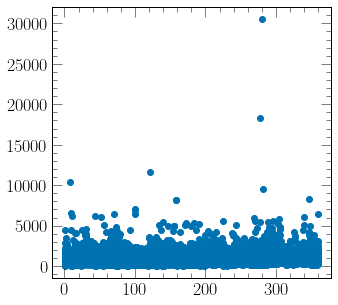

In [54]:
plt.scatter(df["GLON"], df["GAIAEDR3_R_MED_GEO"])

In [55]:
# Calculate galactocentric coordinates
import astropy.coordinates as coord
c = coord.SkyCoord(ra = df["RA"] * u.degree,
                           dec = df["DEC"] * u.degree,
                           distance = df["GAIAEDR3_R_MED_GEO"] * u.pc,
                           frame="icrs")
gc_c = c.transform_to(coord.Galactocentric)
df["R_gal"] = np.array(np.sqrt(gc_c.x**2 + gc_c.y**2) / 1e3)
df["th_gal"] = np.array(np.arctan(gc_c.y/gc_c.x))
df["abs_z"] = np.array(np.abs(gc_c.z) / 1e3)
df["z"] = np.array(gc_c.z / 1e3)


In [113]:
plotting.density_scatter?

Signature:
plotting.density_scatter(
    x,
    y,
    xlim=None,
    ylim=None,
    n_bins=100,
    fig=None,
    ax=None,
    dropna=True,
    density=True,
    **kwargs,
)
Docstring:
Plots the density of the data in each bin provided there is data in the bin. 
The function wrapps matplotlib.pyplot.hist2d, calculating the bins for the histogram.

Parameters
----------
x: listlike
    The x values of each data point to plot
y: listlike
    The y values of each data point to plot
xlim: (float, float)
    The lower and upper bounds on the x axis
ylim: (float, float)
    The lower and upper bounds of the y axis
n_bins: int
    The number of bins to divide each axis into
dropna: bool

Returns
-------
The four outputs from hist2d
File:      ~/surp/plotting_utils.py
Type:      function


# Start here

In [84]:
df = aah.subgiants()
v21 = aah.vincenzo2021()

/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
len(df)

16396

In [10]:
len(v21)

4875

In [183]:
import seaborn as sns

(5.0, 11.0)

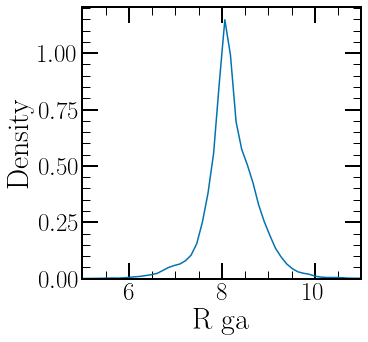

In [184]:
sns.kdeplot(df.R_gal)
plt.xlabel("R ga")
plt.xlim(5, 11)

Text(0, 0.5, 'z (kpc)')

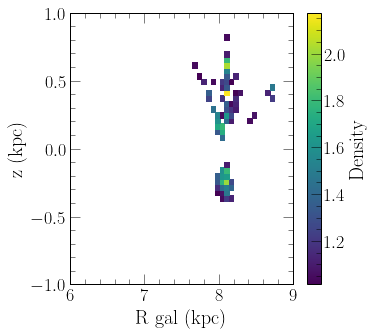

In [86]:
plotting.density_scatter(df.R_gal, df.z, xlim=(6, 9), ylim=(-1, 1), n_bins=50)
plt.xlabel("R gal (kpc)")
plt.ylabel("z (kpc)")

/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


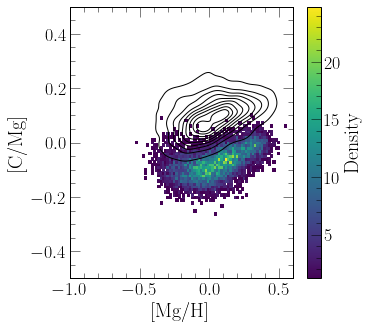

In [87]:
xlim = (-1, 0.6)

filt = ~df["high_alpha"]
plotting.density_scatter(df[filt]["MG_H"], df[filt]["C_MG"], xlim=xlim, ylim=(-0.5, 0.5))
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")
aah.plot_v21_contour("[o/h]", "[c/o]")


(-0.2, 0.5)

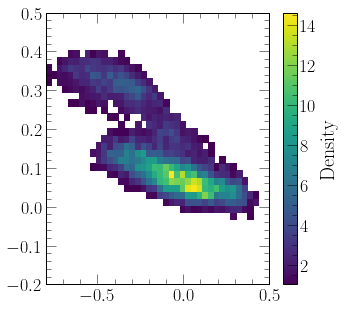

In [88]:
plotting.density_scatter(df["FE_H"], df["MG_FE"]);
plt.xlim(-0.8, 0.5)
plt.ylim(-0.2, 0.5)

(-0.2, 0.5)

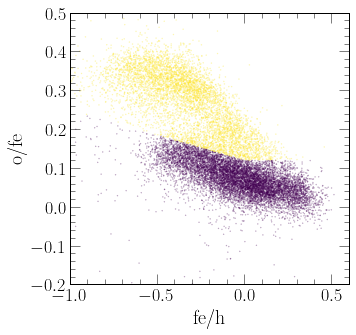

In [92]:


plt.scatter(df["FE_H"], df["MG_FE"], c=df["high_alpha"], s=0.1, alpha=0.5)
plt.xlabel("fe/h")
plt.ylabel('o/fe')
plt.xlim(-1, 0.6)
plt.ylim(-0.2, 0.5)


Plot of the o/fe-fe/h bimodality in apogee data

In [98]:
import sys

In [100]:
sys.path.append("..")

In [ ]:
np.isnan

In [101]:
import apogee_analysis as aah
from vice_to_pickle import plot_mean_track

../VICE/migration/src/plots/env.py:42: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}"]


Text(0, 0.5, '[O/Mg]')

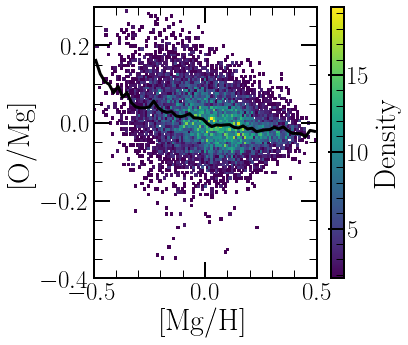

In [136]:
plotting.density_scatter(df["MG_H"], df["O_H"] - df["MG_H"], xlim=(-0.5, 0.5), ylim=(-0.4, 0.3));
plot_mean_track(df["MG_H"], df["O_H"] - df["MG_H"], xlim=(-0.5, 0.5), dropna=True, color="k", lw=3);

plt.xlabel("[Mg/H]")
plt.ylabel("[O/Mg]")

/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([-0.07262308, -0.05965643, -0.07320338, -0.07674088, -0.08773011,
        -0.09398162, -0.09644179, -0.09895688, -0.09707031, -0.09925365,
        -0.08797876, -0.07657256, -0.06648114, -0.05776557, -0.04819869,
        -0.02969707, -0.01343342, -0.01317402, -0.01615176, -0.01592566]),
 array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 ]),
 array([ 7, 21, 17, ..., 12,  1, 14]))

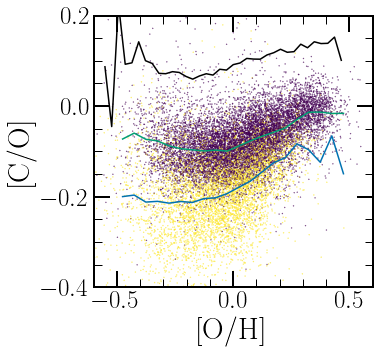

In [172]:
plt.scatter(df["MG_H"], df["C_MG"], s=0.1, c=df["high_alpha"])
ha = df[df["high_alpha"]]
la = df[~df["high_alpha"]]
plt.xlabel("[O/H]")
plt.ylabel("[C/O]")
plt.xlim(-0.6, 0.6)
plt.ylim(-0.4, 0.2)
aah.plot_mean_v21("[o/h]", "[c/o]")
plot_mean_track(ha["MG_H"], ha["C_MG"], bins=20, xlim=(-0.5, 0.5), dropna=True)
plot_mean_track(la["MG_H"], la["C_MG"], bins=20, xlim=(-0.5, 0.5), dropna=True)

In [115]:
import scipy

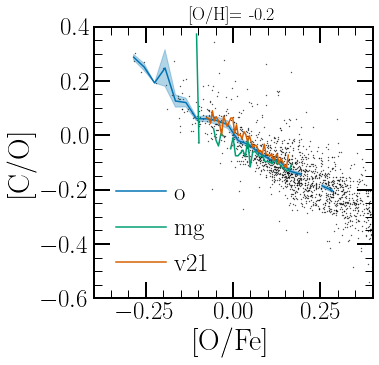

/users/PAS2232/aeyobd/surp/vice_to_pickle.py:386: RuntimeWarning: invalid value encountered in true_divide
  dy = std / np.sqrt(nums)


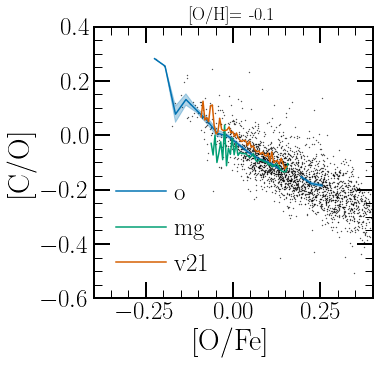

/users/PAS2232/aeyobd/surp/vice_to_pickle.py:386: RuntimeWarning: invalid value encountered in true_divide
  dy = std / np.sqrt(nums)


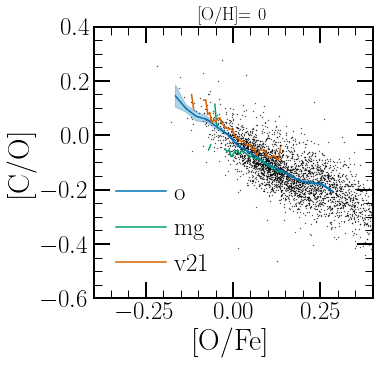

/users/PAS2232/aeyobd/surp/vice_to_pickle.py:386: RuntimeWarning: invalid value encountered in true_divide
  dy = std / np.sqrt(nums)


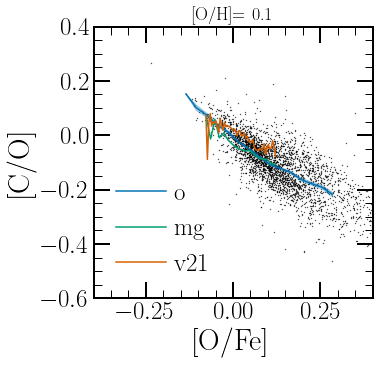

/users/PAS2232/aeyobd/surp/vice_to_pickle.py:386: RuntimeWarning: invalid value encountered in true_divide
  dy = std / np.sqrt(nums)


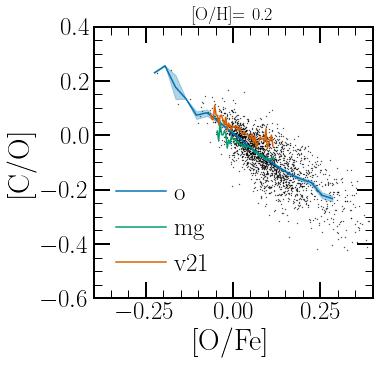

/users/PAS2232/aeyobd/surp/vice_to_pickle.py:386: RuntimeWarning: invalid value encountered in true_divide
  dy = std / np.sqrt(nums)


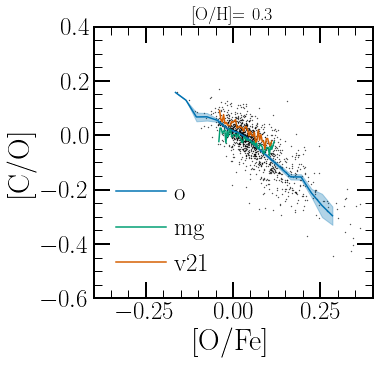

/users/PAS2232/aeyobd/surp/vice_to_pickle.py:386: RuntimeWarning: invalid value encountered in true_divide
  dy = std / np.sqrt(nums)


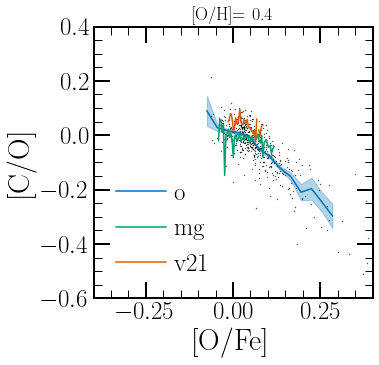

In [188]:
for o0 in [-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4]:
    sl = df["O_H"] > o0-0.05
    sl &= df["O_H"] < o0 + 0.05
    plt.scatter(df[sl]["O_FE"], df[sl]["C_O"], s=0.1, color="k")
    plot_mean_track(df[sl]["O_FE"], df[sl]["C_O"], label="o", shade_width=True, err_mean=True, bins=20, xlim=(-0.3, 0.3))
    plt.xlabel("[O/Fe]")
    plt.ylabel("[C/O]")

    sl = df["MG_H"] > o0-0.05
    sl &= df["MG_H"] < o0 + 0.05
    sl &= ~df["high_alpha"]
    plot_mean_track(df[sl]["MG_FE"], df[sl]["C_MG"], label="mg")

    sl = v21["[o/h]"] > o0-0.05
    sl &= v21["[o/h]"] < o0 + 0.05
    sl &= ~v21["high_alpha"]
    plot_mean_track(v21[sl]["[o/fe]"], v21[sl]["[c/o]"]-0.1, label="v21")

    plt.xlim(-0.4, 0.4)
    plt.ylim(-0.6, 0.4)
    plt.legend()
    plt.title("[O/H]= %s" % o0)
    plt.show()

(array([-0.0344885 ,         nan,         nan,         nan,         nan,
                nan,         nan,  0.075701  ,         nan,  0.015268  ,
        -0.02157549,  0.050641  ,  0.00227482,  0.00120336,  0.01515766,
         0.00657383, -0.04749849, -0.01726284, -0.0318123 , -0.00141939,
        -0.01238043, -0.01767001, -0.01268865, -0.02970117, -0.02265091,
        -0.03544594, -0.03173955, -0.04658423, -0.03431224, -0.04115676,
        -0.04441861, -0.04052622, -0.04497969, -0.04535964, -0.05529534,
        -0.06015299, -0.06476934, -0.0593204 , -0.07294861, -0.07626922,
        -0.07003   , -0.07560289, -0.08475444, -0.09116492, -0.08208886,
        -0.08617679, -0.08716039, -0.0885235 , -0.08110326, -0.08748305]),
 array([-0.08370149, -0.07963602, -0.07557055, -0.07150508, -0.06743961,
        -0.06337414, -0.05930867, -0.0552432 , -0.05117773, -0.04711226,
        -0.04304679, -0.03898132, -0.03491585, -0.03085038, -0.02678491,
        -0.02271944, -0.01865397, -0.0145885 , -0

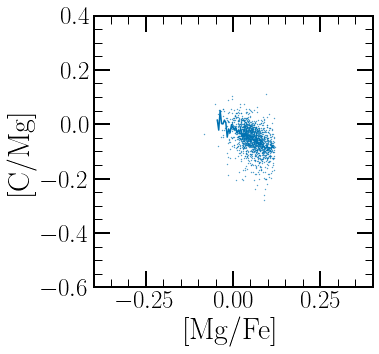

In [154]:

sl = df["MG_H"] > o0-0.05
sl &= df["MG_H"] < o0 + 0.05
sl &= ~df["high_alpha"]
plt.scatter(df[sl]["MG_FE"], df[sl]["C_MG"], s=0.1)
plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")
plt.xlim(-0.4, 0.4)
plt.ylim(-0.6, 0.4)
plot_mean_track(df[sl]["MG_FE"], df[sl]["C_MG"])

In [ ]:
def plot_abundance_alpha(x="O_H", y="C_O", df=split, fig=None, ax=None, s=0.001):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
        
    x_vals = bracket(df, *x.split("_"))
    y_vals = bracket(df, *y.split("_"))
    ax.scatter(x_vals[df.hi_alpha], y_vals[df.hi_alpha], label="low SNIa", alpha=1, s=s)
    ax.scatter(x_vals[~df.hi_alpha], y_vals[~df.hi_alpha], label="high SNIa", alpha=1, s=s)
    ax.legend(markerscale=0.1/s)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    

In [ ]:
plot_abundance_alpha(y="N_O")

In [ ]:
plot_abundance_alpha()
plt.show()

plot_abundance_alpha(y="N_O")
plt.show()

plot_abundance_alpha(y="C_N")
plt.show()

plot_abundance_alpha(y="MG_AL")

In [ ]:
plot_abundance_alpha(x = "MG_H", y = "AL_H")

In [ ]:
def plot_in_gal_region(x="O_H", y="C_O", xlabel=None, ylabel=None):
    fig, axs = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(20,15))
    for j in range(5):
        R_min, R_max = [(1, 3), (3, 5), (5,7), (7,9), (9,11), (11,13)][j]
    

        for i in range(3):
            z_min, z_max = [(0, 0.5), (0.5, 1), (1, 2)][i]
            ax = axs[j][i]
            mask = split.R_gal > R_min
            mask &= split.R_gal < R_max
            mask &= split.abs_z > z_min
            mask &= split.abs_z < z_max
            
            # plotting.density_scatter(x[mask], y[mask], fig=fig, ax=ax)
            plot_abundance_alpha(x, y, df = split[mask], fig=fig, ax=ax, s=0.01)
            ax.set_xlabel("")
            ax.set_ylabel("")
            if j==0:
                ax.set(title="z =  %1.1f - %1.1f" % (z_min, z_max))
            if i == 0:
                ax.set_ylabel("R = %i - %i" %(R_min, R_max))
                

                
    fig.supxlabel("[%s/%s]" % tuple(x.split("_")))
    fig.supylabel("[%s/%s]" % tuple(y.split("_")))
            
            


In [ ]:
plot_in_gal_region(x = "FE_H", y="O_FE")

In [ ]:
plot_in_gal_region(y="C_N")

Plots of C/N vs O/H in different galactic regions 

In [ ]:
plot_in_gal_region(y="C_O")

In [ ]:
plot_in_gal_region(y="N_O")

In [6]:
v21 = aah.vincenzo2021()

/home/daniel/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


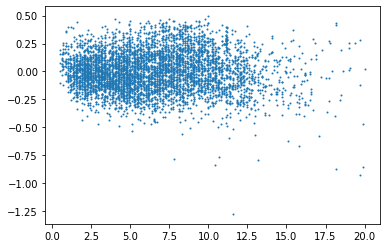

In [7]:
plt.scatter(v21["age"], v21["[o/h]"], s=1)

NameError: name 'df' is not defined

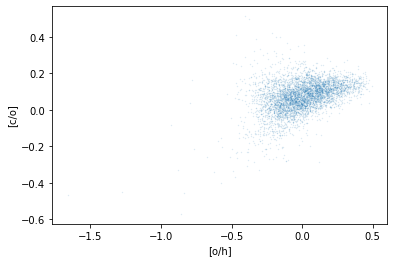

In [8]:
plt.scatter(v21["[o/h]"], v21["[c/o]"], s=0.1, alpha=0.2, label="V21")
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")
plt.scatter(df["O_H"], df["C_O"], s=0.1, alpha=0.1, label="APOGEE")
plt.xlim(-1,0.7)
plt.ylim(-0.7, 0.6)
plt.legend(markerscale=10)

In [5]:
plt.hist(df["VSINI"][df["VSINI"] > 0])

NameError: name 'df' is not defined

Text(0, 0.5, '[c/o]')

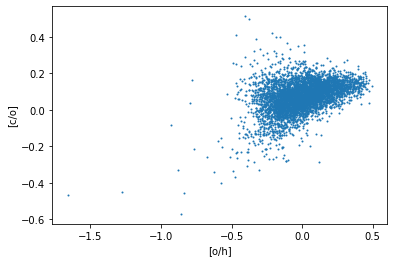

In [9]:
plt.scatter(v21["[o/h]"], v21["[c/o]"], s=1)
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")

Text(0, 0.5, '[C/N]')

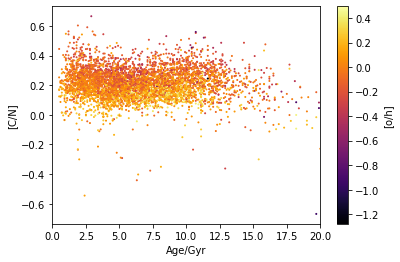

In [10]:
plt.scatter(v21["age"], v21["[c/n]"], s=1, c=v21["[o/h]"], cmap="inferno")
plt.xlim(0, 20)
plt.colorbar(label="[o/h]")
plt.xlabel("Age/Gyr")
plt.ylabel("[C/N]")

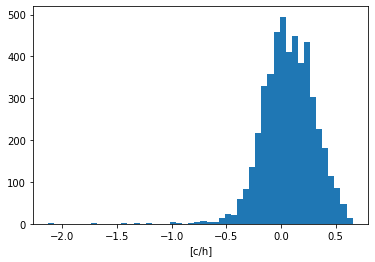

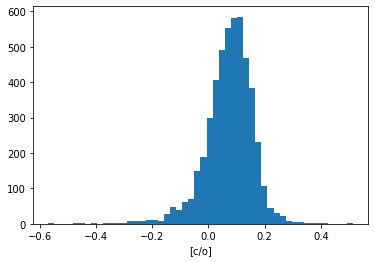

Text(0.5, 0, '[c/n]')

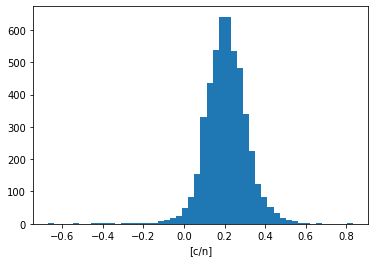

In [11]:
plt.hist(v21["[c/h]"], 50)
plt.xlabel("[c/h]")
plt.show()

plt.hist(v21["[c/o]"], 50)
plt.xlabel("[c/o]")
plt.show()

plt.hist(v21["[c/n]"], 50)
plt.xlabel("[c/n]")


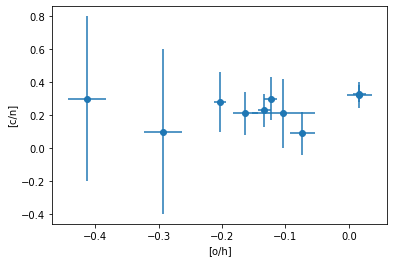

Text(0, 0.5, '[c/o]')

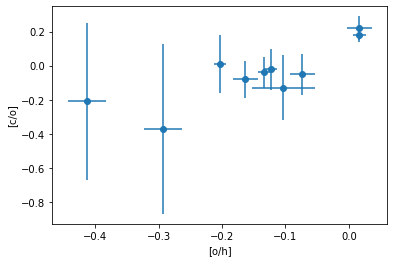

In [12]:
# rom skillman 2020, table 2
# https://ui.adsabs.harvard.edu/abs/2020ApJ...894..138S/abstract

aah.plot_skillman20_cnoh()
plt.xlabel("[o/h]")
plt.ylabel("[c/n]")
plt.show()
aah.plot_skillman20_cooh()
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")

Text(0, 0.5, '[c/o]')

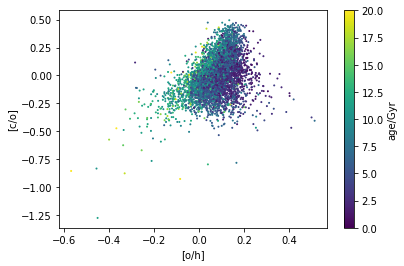

In [13]:
plt.scatter(v21["[c/o]"] , v21["[o/h]"], c=v21["age"], vmin=0, s=1)
plt.colorbar(label="age/Gyr")
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")

In [14]:
plt.scatter(v21["[c/o]"] , v21["[o/h]"], c=v21["[o/fe]"], vmin=0, s=1)
plt.colorbar(label="age/Gyr")
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")

KeyError: '[o/fe]'

In [12]:
v21

,[mg/fe],[fe/h],[c/fe],[n/fe],[c/h],[n/h],age,[c/n],[o/h],[n/o],[c/o],[c+n/h],[c+n/o]
0,0.247532,-0.292042,0.158510,0.052401,-0.069385,-0.436210,10.1,0.376624,-0.079585,-0.356624,0.010201,-0.129447,-0.049862
1,0.042202,0.049127,-0.016018,0.197207,0.113361,0.006940,8.5,0.116219,0.073644,-0.066703,0.039717,0.091440,0.017796
2,0.290692,-0.351292,0.153900,0.091762,-0.122959,-0.484260,8.8,0.371100,-0.169290,-0.314970,0.046331,-0.182400,-0.013110
3,0.027853,-0.178222,-0.012749,0.202450,-0.069914,-0.290230,3.6,0.230115,-0.128322,-0.161908,0.058408,-0.110926,0.017395
4,0.257632,-0.211932,0.168140,0.196530,0.010191,-0.179516,13.7,0.199505,0.014441,-0.193956,-0.004250,-0.026094,-0.040535
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5071,0.054724,-0.221732,-0.112970,0.360880,-0.153254,-0.250104,1.6,0.106649,-0.229760,-0.020344,0.076506,-0.173374,0.056385
5072,0.063233,0.008628,-0.007638,0.167090,0.081244,-0.063674,9.1,0.154717,0.041089,-0.104763,0.040155,0.052400,0.011311
5073,0.109576,0.281778,0.107047,0.196150,0.447155,0.301935,11.1,0.155018,0.364991,-0.063056,0.082164,0.418258,0.053267
5074,-0.041400,0.154678,-0.060001,0.448730,0.266917,0.225569,1.0,0.051146,0.167322,0.058247,0.099595,0.257891,0.090569


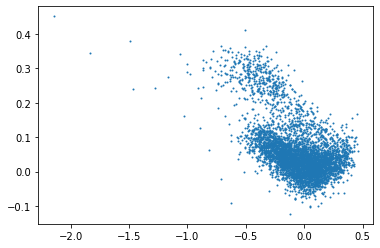

In [21]:
plt.scatter(v21["[fe/h]"], v21["[mg/fe]"], s=1)

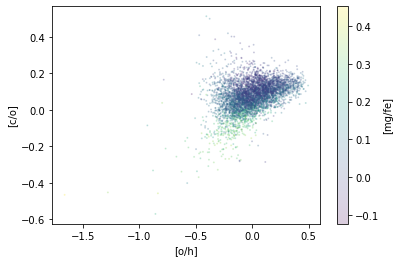

In [34]:
plt.scatter(v21["[o/h]"], v21["[c/o]"], c=v21["[mg/fe]"], s=1, alpha=0.2)
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")
plt.colorbar(label="[mg/fe]")

In [15]:
plt.scatter(v21["age"], v21["[cn/h]"] - v21["[o/h]"], c=v21["[o/h]"], s=1, alpha=0.5)
plt.xlabel("age")
plt.ylabel("[c+n/o]")
plt.colorbar(label="[o/h]")
plt.xlim(0, 15)

KeyError: '[cn/h]'

In [16]:
plt.scatter(v21["[o/h]"], v21["[c-n/h]"] - v21["[o/h]"], c=v21["age"], vmin=0, vmax=14, s=1, alpha=0.5)
plt.xlabel("[o/h]")
plt.ylabel("[c-n/o]")
plt.colorbar(label="age/Gyr")

KeyError: '[c-n/h]'

In [17]:
plt.scatter(v21["age"], v21["[c-n/h]"] - v21["[o/h]"], c=v21["[o/h]"], s=1, alpha=0.5)
plt.xlabel("age")
plt.ylabel("[c-n/o]")
plt.xlim(0, 15)
plt.colorbar(label="[o/h]")

KeyError: '[c-n/h]'

# Quantifying scatter

In [ ]:
plt.hist(df["O_FE_ERR"], 100);

In [ ]:
plt.hist(df["O_FE_ERR"], 1000);
plt.xlim(0, 1)

In [ ]:
plt.hist(df["FE_H_ERR"], 100);

# MultiProcess Model

Trying to apply methods from W+19 to AGB star yields. 